## Initial machine learning training
Goal: Develop a baseline machine learning model that emulates surface air temperature (TAS) over time using historical climate model outputs.
Plan:  
- Load and preprocess TAS data from the SPEAR model archive
- Standardize and prepare spatial-temporal input data
- Implement a simple deep learning model (2D CNN) to predict TAS at time t from preceding timesteps (t–n, …, t–1).
- Evaluate baseline model performance using standard metrics

In [9]:
from utils.utils import VarData
from architectures.cnn_baseline import CNN2D_Baseline, set_seed

filename = "DATA/atmos.192101-201012.t_ref.nc"
variable = "t_ref"
num_epochs = 50
set_seed()

Tas = VarData(filename, variable)
Tas.load_data()
Tas.interpolate_data()
Tas.add_spatial_features()
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_train, y_test, time_test = Tas.split_data()

# Reshape X_train and X_test for a 2D conv (i.e (N_samples, lags*5, lat, lon))
X_train_scaled = Tas.reshape_for_model(X_train_scaled, model_type="2dcnn")
X_test_scaled = Tas.reshape_for_model(X_test_scaled, model_type="2dcnn")

# Reshape y_train and y_test to be consistent (i.e (N_samples, 1, lat, lon))
y_train_scaled = y_train_scaled[:, None, :, :]
y_test_scaled  = y_test_scaled[:, None, :, :]

t_ref - INFO - Working on var: t_ref from DATA/atmos.192101-201012.t_ref.nc


In [10]:
# Baseline CNN2D Model
set_seed()
Baseline = CNN2D_Baseline(in_channels=X_train_scaled.shape[1])
train_loader, test_loader = Baseline.create_data_loaders(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
Baseline.train_model(train_loader, test_loader, num_epochs=num_epochs)

# Rerunning it again to confirm reproducibility
# set_seed()
# Baseline2 = CNN2D_Baseline(in_channels=X_train_scaled.shape[1], label="baseline.redo")
# train_loader, test_loader = Baseline2.create_data_loaders(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
# Baseline2.train_model(train_loader, test_loader, num_epochs=num_epochs)

Model Architecture:
Sequential(
  (0): Conv2d(15, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [11]:
# Baseline CNN2D Model with BatchNorm
set_seed()
Baseline_batchnorm = CNN2D_Baseline(in_channels=X_train_scaled.shape[1], case=1, label="baseline_batchnorm")
train_loader, test_loader = Baseline_batchnorm.create_data_loaders(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
Baseline_batchnorm.train_model(train_loader, test_loader, num_epochs=num_epochs)

# set_seed()
# Baseline_batchnorm2 = CNN2D_Baseline(in_channels=X_train_scaled.shape[1], case=1, label="baseline_batchnorm.redo")
# train_loader, test_loader = Baseline_batchnorm2.create_data_loaders(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
# Baseline_batchnorm2.train_model(train_loader, test_loader, num_epochs=num_epochs)

Model Architecture:
Sequential(
  (0): Conv2d(15, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## Simple encoder–decoder CNN
1) ENCODES the input
    - make is smaller (downscales) with more features
2) PROCESSES it
    - network is forced to represent all information in a smaller space
3) DECODES it
    - makes it bigger (upscales) to the original image

In [12]:
# Baseline CNN2D Model with BatchNorm and Sampling
set_seed()
Baseline_batchnorm_sampling = CNN2D_Baseline(in_channels=X_train_scaled.shape[1], case=2, label="Baseline_batchnorm_sampling")
train_loader, test_loader = Baseline_batchnorm_sampling.create_data_loaders(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
Baseline_batchnorm_sampling.train_model(train_loader, test_loader, num_epochs=num_epochs)

# set_seed()
# Baseline_batchnorm_sampling = CNN2D_Baseline(in_channels=X_train_scaled.shape[1], case=2, label="Baseline_batchnorm_sampling.redo")
# train_loader, test_loader = Baseline_batchnorm_sampling.create_data_loaders(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
# Baseline_batchnorm_sampling.train_model(train_loader, test_loader, num_epochs=num_epochs)

Model Architecture:
Sequential(
  (0): Conv2d(15, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Conv2d(16, 1, kernel_size=(3, 3), stride=(1,

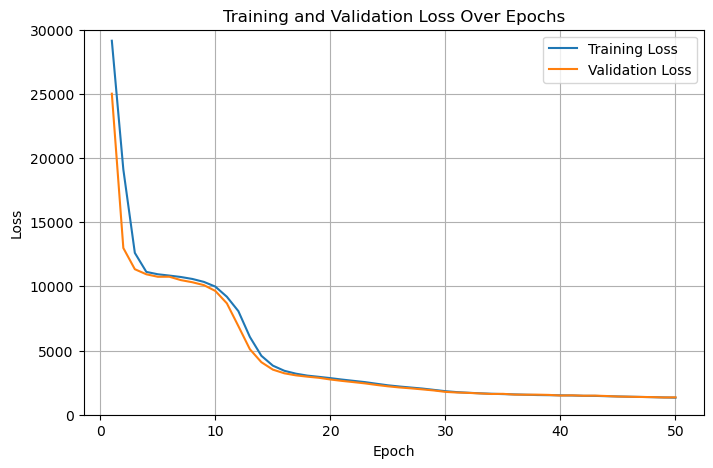

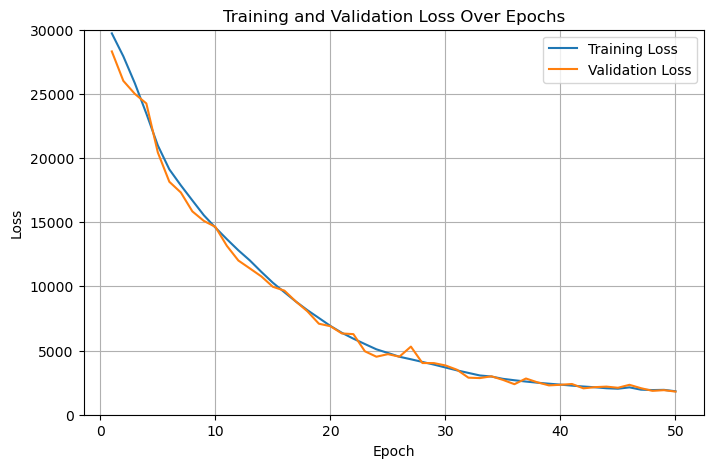

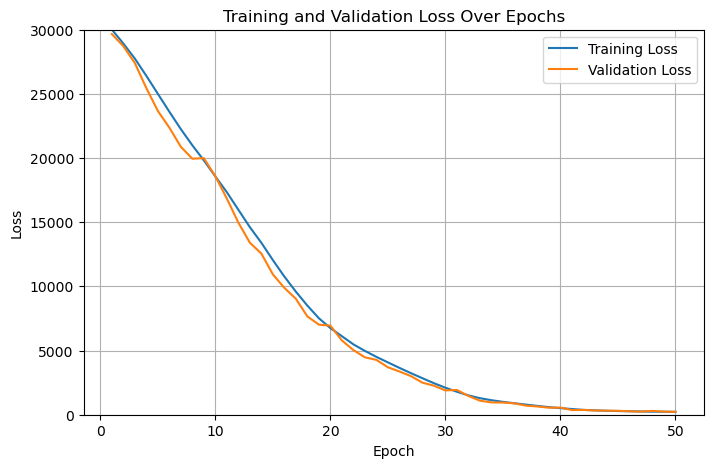

In [13]:
Baseline.plot_loss_over_epochs()
Baseline_batchnorm.plot_loss_over_epochs()
Baseline_batchnorm_sampling.plot_loss_over_epochs()

Global RMSE (K): 81.016032
Global Persistence RMSE (K): 277.208888


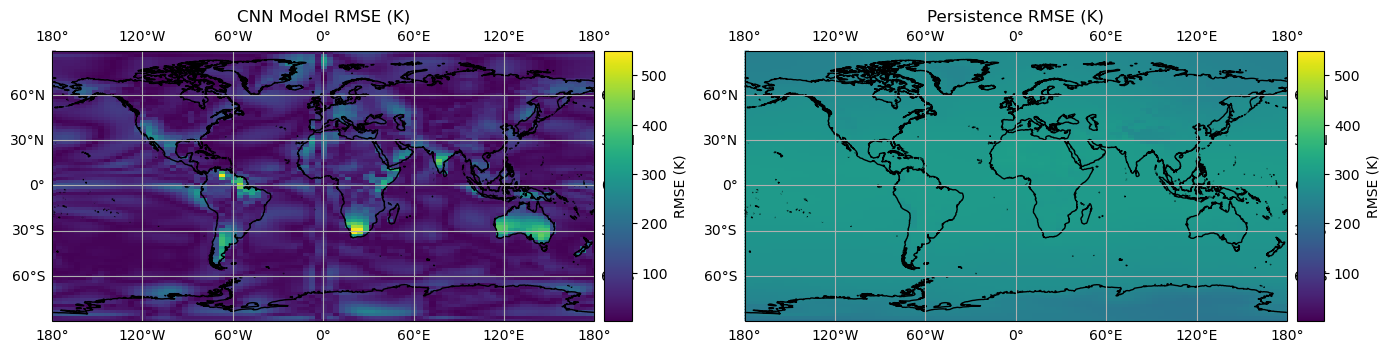

Global RMSE (K): 103.547640
Global Persistence RMSE (K): 277.208888


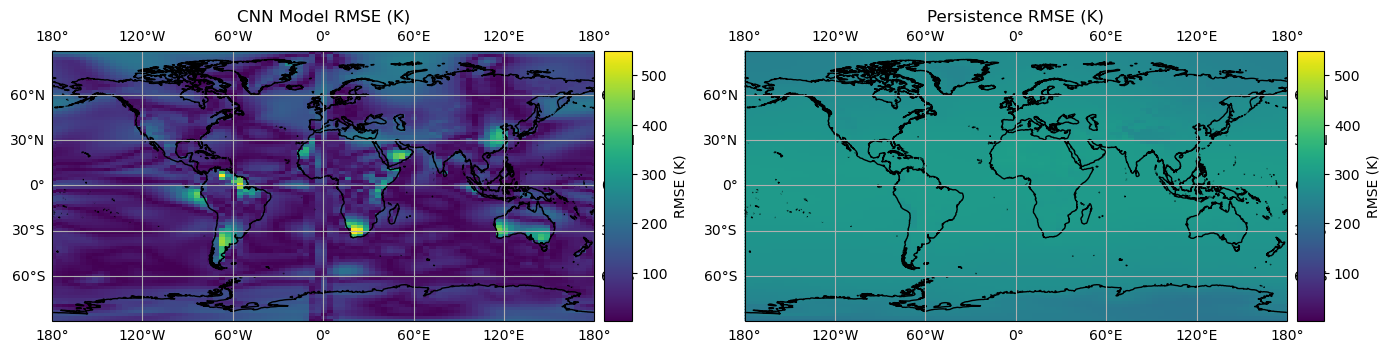

Global RMSE (K): 53.384683
Global Persistence RMSE (K): 277.208888


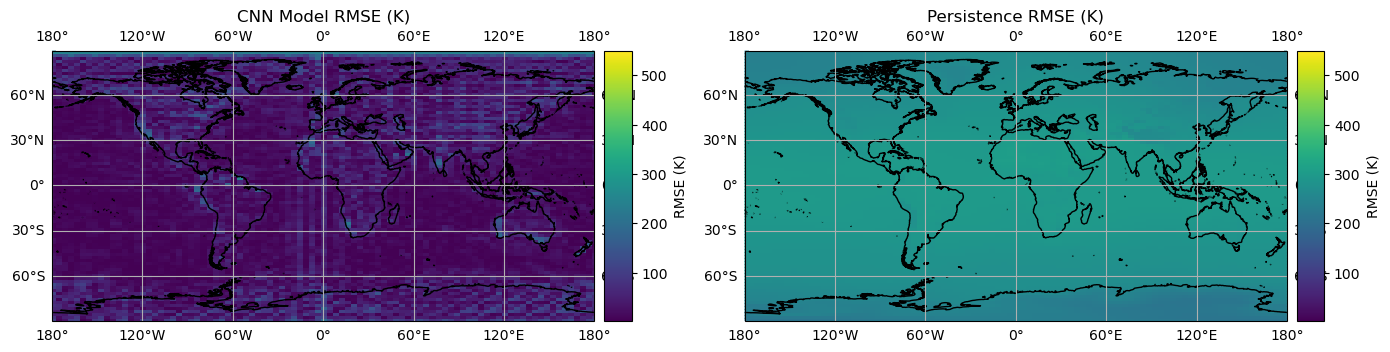

In [15]:
ranges = Baseline.get_rmse(Tas, X_test_scaled, y_test_scaled)
_ = Baseline_batchnorm.get_rmse(Tas, X_test_scaled, y_test_scaled, ranges=ranges)
_ = Baseline_batchnorm_sampling.get_rmse(Tas, X_test_scaled, y_test_scaled, ranges=ranges)

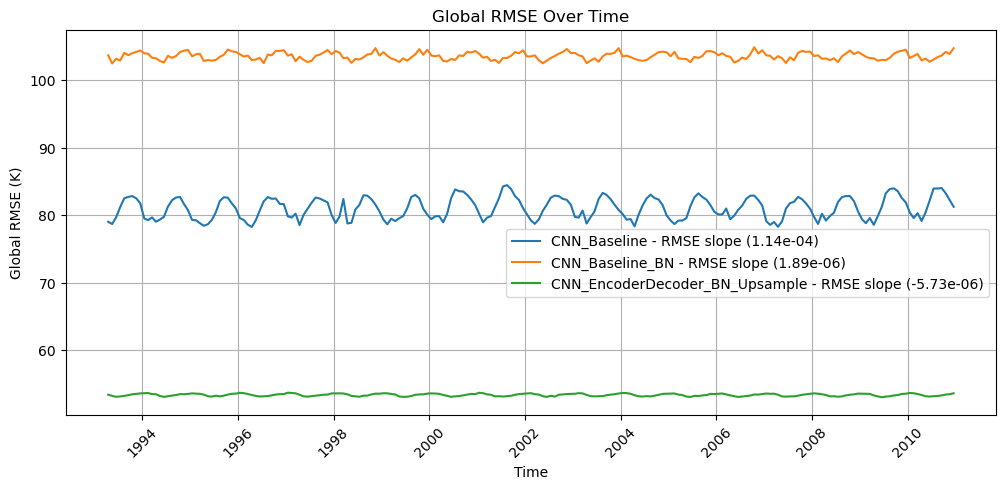

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import numpy as np

Models = [{'Model Name': 'CNN_Baseline', 'Trained Model': Baseline, 'RMSE': None, 'Slope': None},
          {'Model Name': 'CNN_Baseline_BN', 'Trained Model': Baseline_batchnorm, 'RMSE':None, 'Slope': None},
          {'Model Name': 'CNN_EncoderDecoder_BN_Upsample', 'Trained Model': Baseline_batchnorm_sampling, 'RMSE': None, 'Slope': None}]

time_test_plot = np.array([np.datetime64(t) for t in time_test])
plt.figure(figsize=(12,5))
for Model in Models:
    Model['RMSE'] = Model['Trained Model'].get_global_rmse_over_time(Tas, X_test_scaled, y_test_scaled)
    rmse = Model['RMSE']
    name = Model['Model Name']

    x = time_test_plot[3:].astype('datetime64[D]').astype(float)
    Model['slope'], intercept, r_value, p_value, std_err = linregress(x, rmse)
    plt.plot(time_test_plot[3:], rmse, label=f"{name} - RMSE slope ({Model['slope']:.2e})")


plt.xlabel("Time")
plt.ylabel("Global RMSE (K)")
plt.title("Global RMSE Over Time")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))  # every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()

